# Tutorial: Magnetic field processing

This tutorial will teach you how to perform the processing steps which require magnetic field calculations like mapping along the field line and calculations of adiabatic invariants.

We will use the time-binned variables from the cdf file for the tutorial. We also use energies and pitch angles for this tutorial and fold the pitch angles around 90 degrees assuming a symmetric pitch-angle distribution.

In [ ]:
from datetime import datetime, timedelta, timezone

from astropy import units as u

import el_paso as ep

extraction_infos = [
    ep.ExtractionInfo(
        result_key="Epoch",
        name_or_column="Epoch_Ele",
        unit=u.tt2000,
    ),
    ep.ExtractionInfo(
        result_key="Energy",
        name_or_column="HOPE_ENERGY_Ele",
        unit=u.eV,
    ),
    ep.ExtractionInfo(
        result_key="Pitch_angle",
        name_or_column="PITCH_ANGLE",
        unit=u.deg,
        is_time_dependent=False,
    ),
    ep.ExtractionInfo(
        result_key="FEDU",
        name_or_column="FEDU",
        unit=(u.cm**2 * u.s * u.sr * u.keV) ** (-1),
    ),
    ep.ExtractionInfo(
        result_key="xGEO",
        name_or_column="Position_Ele",
        unit=u.km,
    ),
]

start_time = datetime(2017, 7, 30, tzinfo=timezone.utc)
end_time = datetime(2017, 8, 1, 23, 59,59, tzinfo=timezone.utc)

file_name_stem = "rbspa_rel04_ect-hope-pa-l3_YYYYMMDD_.{6}.cdf"

ep.download(start_time, end_time,
             save_path=".",
             download_url="https://spdf.gsfc.nasa.gov/pub/data/rbsp/rbspa/l3/ect/hope/pitchangle/rel04/YYYY/",
             file_name_stem=file_name_stem,
             file_cadence="daily",
             method="request",
             skip_existing=True)

variables = ep.extract_variables_from_files(start_time, end_time, "daily",
                                             data_path=".", file_name_stem=file_name_stem,
                                             extraction_infos=extraction_infos)

time_bin_methods = {
    "xGEO": ep.TimeBinMethod.NanMean,
    "Energy": ep.TimeBinMethod.NanMedian,
    "FEDU": ep.TimeBinMethod.NanMedian,
    "Pitch_angle": ep.TimeBinMethod.Repeat,
}

binned_time_variable = ep.processing.bin_by_time(variables["Epoch"], variables=variables,
                                                 time_bin_method_dict=time_bin_methods,
                                                 time_binning_cadence=timedelta(minutes=5))

variables["FEDU"].transpose_data([0,2,1]) # making it having dimensions (time, energy, pitch angle)
ep.processing.fold_pitch_angles_and_flux(variables["FEDU"],
                                         variables["Pitch_angle"])

print(variables["FEDU"].metadata.processing_notes)
asdf

# not needed anymore
del variables["Epoch"]


File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf
File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf
File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf
Extracting variables ...
Concatenating data for Epoch_Ele ...
Concatenating data for HOPE_ENERGY_Ele ...
Concatenating data for FEDU ...
Concatenating data for Position_Ele ...
Concatenating data for Epoch_Ele ...
Concatenating data for HOPE_ENERGY_Ele ...
Concatenating data for FEDU ...
Concatenating data for Position_Ele ...
		Finished in 0.769 seconds
Time binning ...
		Finished in 3.261 seconds
Folding pitch angles and flux ...
		Finished in 0.184 seconds
VariableMetadata(unit=Unit("1 / (keV s sr cm2)"), original_cadence_seconds=0, source_files=['rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf'], description='', processing_notes

NameError: name 'asdf' is not defined

Now we are ready to perform the magnetic field calculations. To make this most efficient, there exists a single function, which calculates all derived variables at once.
The use specifies which variables should be calculated, which magnetic field model should be used, and which options for IRBEM are chosen (IRBEM is the underlying library performing the magnetic field calculations).

We will start by calculating just the variables which dependent on the satellite's position but not on the particles. The full list of available variable names can be found HERE. 

		Finished in 0.031 seconds
		Finished in 0.039 seconds


  1%|          | 6/864 [00:01<02:23,  5.98it/s]    

		Finished in 1.155 seconds


Text(0, 0.5, 'R_eq (RE)')

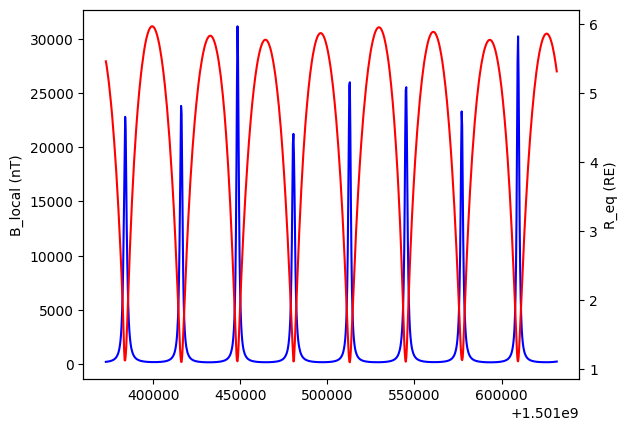

In [4]:
# Calculate magnetic field variables
from matplotlib import pyplot as plt

num_cores = 4
irbem_options = [1, 1, 4, 4, 0]
irbem_lib_path = "../IRBEM/libirbem.so"

var_names_to_compute = ["B_local_T89", "MLT_T89", "B_eq_T89", "R_eq_T89"]

magnetic_field_variables = ep.processing.compute_magnetic_field_variables(time_var = binned_time_variable,
                                                                          xgeo_var = variables["xGEO"],
                                                                          var_names_to_compute = var_names_to_compute,
                                                                          irbem_lib_path = irbem_lib_path,
                                                                          irbem_options = irbem_options,
                                                                          num_cores = num_cores)

plt.plot(binned_time_variable.get_data(), magnetic_field_variables["B_local_T89"].get_data(), "b", label="B_local")
plt.ylabel("B_local (nT)")

yyaxis = plt.gca().twinx()
yyaxis.plot(binned_time_variable.get_data(), magnetic_field_variables["R_eq_T89"].get_data(), "r", label="R_eq")
plt.xlabel("Time")
plt.ylabel("R_eq (RE)")


Next, we want to calculate equatorial pitch angles and adiabatic invariants. In this case, we have to provide the pitch-angles and energy variables as well.

The calculation of Lstar is quite heavy, so we will only calculate a small time frame for this tutorial.

		Finished in 0.001 seconds
		Finished in 0.001 seconds


 33%|███▎      | 1/3 [00:01<00:02,  1.00s/it]   

		Finished in 1.156 seconds
	Calculating equatorial pitch angle ...
		Equatorial pitch angle calculation finished in 0.000 seconds
	Calculating invariant mu ...
		Invariant mu calculation finished in 0.001 seconds
	Calculating invariant K ...



  0%|          | 0/3 [00:04<?, ?it/s]

		Finished in 4.186 seconds



  0%|          | 0/3 [00:01<?, ?it/s]


		Finished in 1.117 seconds
		Invariant K calculation finished in 5.304 seconds
Saving file test.h5...
		Finished in 0.012 seconds


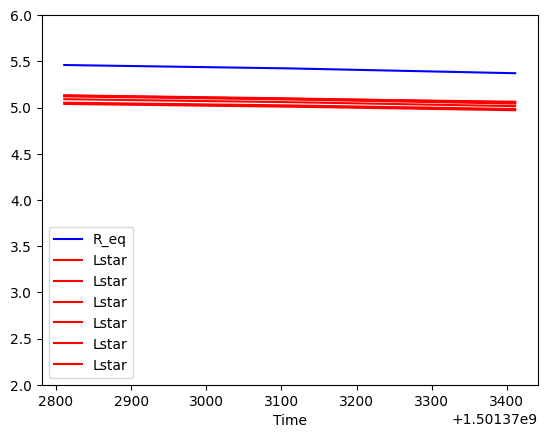

In [ ]:

for var in variables.values():
    var.truncate(binned_time_variable, start_time=start_time, end_time=start_time + timedelta(hours=0.2))
binned_time_variable.truncate(binned_time_variable, start_time=start_time, end_time=start_time + timedelta(hours=0.2))

var_names_to_compute = ["B_local_T89", "MLT_T89", "B_eq_T89", "R_eq_T89", "PA_eq_T89", "invMu_T89", "invK_T89", "Lstar_T89"]

magnetic_field_variables = ep.processing.compute_magnetic_field_variables(time_var = binned_time_variable,
                                                                          xgeo_var = variables["xGEO"],
                                                                          energy_var = variables["Energy"],
                                                                          pa_local_var = variables["Pitch_angle"],
                                                                          particle_species = "electron",
                                                                          var_names_to_compute = var_names_to_compute,
                                                                          irbem_lib_path = irbem_lib_path,
                                                                          irbem_options = irbem_options,
                                                                          num_cores = num_cores)

plt.plot(binned_time_variable.get_data(), magnetic_field_variables["R_eq_T89"].get_data(), "b", label="R_eq")
plt.plot(binned_time_variable.get_data(), magnetic_field_variables["Lstar_T89"].get_data(), "r", label="Lstar")

plt.xlabel("Time")
plt.legend()
plt.ylim((2, 6))